# 📊 BigData Analysis: Pandas vs DuckDB Performance Comparison

**For MBA Students - Understanding Big Data Technology Choices**

This notebook demonstrates the practical differences between traditional data processing (pandas) and modern analytical databases (DuckDB) when working with large datasets.

## 🎯 Learning Objectives
- Understand memory limitations of traditional tools
- See how modern tools handle large datasets efficiently
- Learn business implications of technology choices
- Analyze cost, performance, and reliability trade-offs

## 🔧 Setup and Dependencies

First, let's install the required packages and set up our environment.

In [2]:
# Install required packages
!uv pip install -q pandas duckdb psutil matplotlib seaborn requests

In [3]:
# Import required libraries
import pandas as pd
import duckdb
import psutil
import time
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from IPython.display import display, HTML
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

## 💻 System Information

Let's check our system specifications to understand the constraints we're working with.

In [4]:
# Helper functions
def get_memory_usage():
    """Get current memory usage in MB"""
    process = psutil.Process()
    return process.memory_info().rss / 1024 / 1024

def format_memory(mb):
    """Format memory usage for display"""
    if mb > 1024:
        return f"{mb/1024:.1f} GB"
    return f"{mb:.1f} MB"

# Display system information
print("🖥️  SYSTEM SPECIFICATIONS")
print("=" * 40)
print(f"Total Memory: {format_memory(psutil.virtual_memory().total / 1024 / 1024)}")
print(f"Available Memory: {format_memory(psutil.virtual_memory().available / 1024 / 1024)}")
print(f"CPU Cores: {psutil.cpu_count()}")
print(f"Current Memory Usage: {format_memory(get_memory_usage())}")
print("=" * 40)

🖥️  SYSTEM SPECIFICATIONS
Total Memory: 12.7 GB
Available Memory: 11.5 GB
CPU Cores: 2
Current Memory Usage: 248.6 MB


## 📁 Dataset Information

We'll test with three datasets of increasing size hosted on Google Cloud Storage:

- **Small**: 100K records (~2MB) - Comfortable for any system
- **Medium**: 10M records (~200MB) - Shows memory pressure
- **Large**: 100M records (~2GB) - Likely to cause memory issues

Each dataset contains synthetic temperature measurements from weather stations worldwide.

In [5]:
# Dataset URLs and local filenames
datasets = [
    ("https://storage.googleapis.com/bigdata2025/duckdb/small_dataset.csv", "small_dataset.csv", "Small (100K records)", 100_000),
    ("https://storage.googleapis.com/bigdata2025/duckdb/medium_dataset.csv", "medium_dataset.csv", "Medium (10M records)", 10_000_000),
    ("https://storage.googleapis.com/bigdata2025/duckdb/large_dataset.csv", "large_dataset.csv", "Large (100M records)", 100_000_000),
]

print("📊 DATASETS TO TEST")
print("=" * 50)
for url, filename, description, records in datasets:
    print(f"• {description}: {records:,} records")
    print(f"  URL: {url}")
    print(f"  Local file: {filename}")
    # Download the dataset
    print(f"  Downloading {filename}...")
    !wget -q -O {filename} {url}
    print("  Download complete.")
    print()

📊 DATASETS TO TEST
• Small (100K records): 100,000 records
  URL: https://storage.googleapis.com/bigdata2025/duckdb/small_dataset.csv
  Local file: small_dataset.csv
  Download complete.

• Medium (10M records): 10,000,000 records
  URL: https://storage.googleapis.com/bigdata2025/duckdb/medium_dataset.csv
  Local file: medium_dataset.csv
  Download complete.

• Large (100M records): 100,000,000 records
  URL: https://storage.googleapis.com/bigdata2025/duckdb/large_dataset.csv
  Local file: large_dataset.csv
  Download complete.



## 🔧 Testing Functions

Let's define our testing functions to measure performance and memory usage for both pandas and DuckDB.

In [6]:
def test_pandas(filename, description):
    """Test pandas performance"""
    print(f"  🐼 Testing pandas on {description}...")

    mem_before = get_memory_usage()
    start_time = time.time()

    try:
        # Load data
        df = pd.read_csv(filename, sep=';', names=['station', 'temperature'])
        load_time = time.time()

        # Perform aggregation
        result = df.groupby('station')['temperature'].agg(['min', 'mean', 'max']).reset_index()
        end_time = time.time()

        mem_after = get_memory_usage()

        return {
            'success': True,
            'load_time': load_time - start_time,
            'total_time': end_time - start_time,
            'memory_used': mem_after - mem_before,
            'records': len(df),
            'stations': len(result)
        }

    except MemoryError:
        return {
            'success': False,
            'error': 'Out of memory',
            'memory_used': get_memory_usage() - mem_before
        }
    except Exception as e:
        return {
            'success': False,
            'error': str(e),
            'memory_used': get_memory_usage() - mem_before
        }

In [7]:
def test_duckdb(filename, description):
    """Test DuckDB performance"""
    print(f"  🦆 Testing DuckDB on {description}...")

    mem_before = get_memory_usage()
    start_time = time.time()

    try:
        conn = duckdb.connect()

        query = """
        SELECT
            station,
            MIN(temperature) as min_temp,
            AVG(temperature) as mean_temp,
            MAX(temperature) as max_temp,
            COUNT(*) as record_count
        FROM read_csv(?,
            header=false,
            columns={'station': 'VARCHAR', 'temperature': 'DOUBLE'},
            delim=';'
        )
        GROUP BY station
        ORDER BY station
        """

        result = conn.execute(query, [filename]).fetchall()
        end_time = time.time()

        conn.close()
        mem_after = get_memory_usage()

        total_records = sum(row[4] for row in result)

        return {
            'success': True,
            'total_time': end_time - start_time,
            'memory_used': mem_after - mem_before,
            'records': total_records,
            'stations': len(result)
        }

    except Exception as e:
        return {
            'success': False,
            'error': str(e),
            'memory_used': get_memory_usage() - mem_before
        }

## ⚡ Performance Comparison

Now let's run the actual comparison! Watch the memory usage and processing times.

**Expected Results:**
- Pandas: Fast on small data, struggles with large datasets
- DuckDB: Consistent performance across all dataset sizes

In [17]:
print("⚡ PANDAS vs DUCKDB PERFORMANCE COMPARISON")
print("=" * 60)

results = []

for url, filename, description, expected_records in datasets:
    print(f"\n📊 Testing {description}")
    print("-" * 40)

    # Test pandas
    pandas_result = test_pandas(filename, description)
    time.sleep(1)  # Let system recover

    # Test DuckDB
    duckdb_result = test_duckdb(filename, description)
    time.sleep(1)  # Let system recover

    # Store results
    results.append({
        'dataset': description,
        'url': url,
        'expected_records': expected_records,
        'pandas': pandas_result,
        'duckdb': duckdb_result
    })

    # Print comparison for this dataset
    print(f"\n  📈 Results for {description}:")

    if pandas_result['success']:
        print(f"    Pandas:  {pandas_result['total_time']:.2f}s, {format_memory(pandas_result['memory_used'])} memory")
    else:
        print(f"    Pandas:  ❌ {pandas_result['error']} ({format_memory(pandas_result['memory_used'])} memory)")

    if duckdb_result['success']:
        print(f"    DuckDB:  {duckdb_result['total_time']:.2f}s, {format_memory(duckdb_result['memory_used'])} memory")
    else:
        print(f"    DuckDB:  ❌ {duckdb_result['error']} ({format_memory(duckdb_result['memory_used'])} memory)")

    # Show speedup/efficiency if both succeeded
    if pandas_result['success'] and duckdb_result['success']:
        speedup = pandas_result['total_time'] / duckdb_result['total_time']
        memory_ratio = pandas_result['memory_used'] / max(duckdb_result['memory_used'], 1)
        print(f"    💡 DuckDB is {speedup:.1f}x faster and uses {memory_ratio:.1f}x less memory")

print("\n✅ Performance testing complete!")

⚡ PANDAS vs DUCKDB PERFORMANCE COMPARISON

📊 Testing Small (100K records)
----------------------------------------
  🐼 Testing pandas on Small (100K records)...
  🦆 Testing DuckDB on Small (100K records)...

  📈 Results for Small (100K records):
    Pandas:  0.06s, 10.7 MB memory
    DuckDB:  0.07s, -14.3 MB memory
    💡 DuckDB is 0.9x faster and uses 10.7x less memory

📊 Testing Medium (10M records)
----------------------------------------
  🐼 Testing pandas on Medium (10M records)...
  🦆 Testing DuckDB on Medium (10M records)...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


  📈 Results for Medium (10M records):
    Pandas:  5.96s, 202.2 MB memory
    DuckDB:  2.18s, -50.2 MB memory
    💡 DuckDB is 2.7x faster and uses 202.2x less memory

📊 Testing Large (100M records)
----------------------------------------
  🐼 Testing pandas on Large (100M records)...
  🦆 Testing DuckDB on Large (100M records)...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


  📈 Results for Large (100M records):
    Pandas:  51.47s, 1.5 GB memory
    DuckDB:  22.93s, -3.0 MB memory
    💡 DuckDB is 2.2x faster and uses 1533.2x less memory

✅ Performance testing complete!


## 📊 Performance Summary Table

Let's create a clean summary table of our results.

In [18]:
# Create summary table
print(f"{'='*80}")
print("📊 PERFORMANCE SUMMARY")
print(f"{'='*80}")

print(f"{'Dataset':<20} {'Pandas Time':<15} {'DuckDB Time':<15} {'Pandas Memory':<15} {'DuckDB Memory':<15}")
print("-" * 80)

for result in results:
    dataset = result['dataset'].split('(')[0].strip()

    pandas_time = f"{result['pandas']['total_time']:.2f}s" if result['pandas']['success'] else "FAILED"
    duckdb_time = f"{result['duckdb']['total_time']:.2f}s" if result['duckdb']['success'] else "FAILED"
    pandas_mem = format_memory(result['pandas']['memory_used'])
    duckdb_mem = format_memory(result['duckdb']['memory_used'])

    print(f"{dataset:<20} {pandas_time:<15} {duckdb_time:<15} {pandas_mem:<15} {duckdb_mem:<15}")

📊 PERFORMANCE SUMMARY
Dataset              Pandas Time     DuckDB Time     Pandas Memory   DuckDB Memory  
--------------------------------------------------------------------------------
Small                0.06s           0.07s           10.7 MB         -14.3 MB       
Medium               5.96s           2.18s           202.2 MB        -50.2 MB       
Large                51.47s          22.93s          1.5 GB          -3.0 MB        


## 📈 Performance Visualization

Let's create some charts to visualize the performance differences.

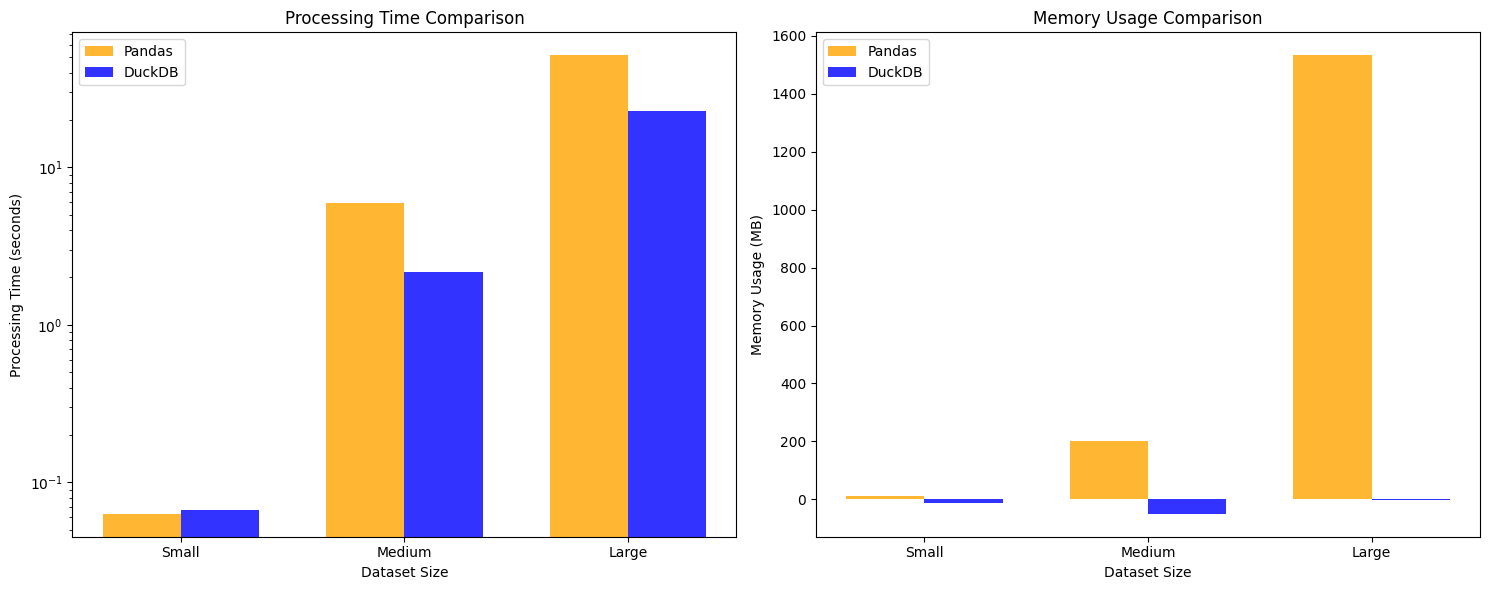

In [23]:
# Prepare data for plotting
dataset_names = []
pandas_times = []
duckdb_times = []
pandas_memory = []
duckdb_memory = []

for result in results:
    dataset_names.append(result['dataset'].split('(')[0].strip())

    if result['pandas']['success']:
        pandas_times.append(result['pandas']['total_time'])
        pandas_memory.append(result['pandas']['memory_used'])
    else:
        pandas_times.append(None)
        pandas_memory.append(None)

    if result['duckdb']['success']:
        duckdb_times.append(result['duckdb']['total_time'])
        duckdb_memory.append(result['duckdb']['memory_used'])
    else:
        duckdb_times.append(None)
        duckdb_memory.append(None)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Processing Time Comparison
x = range(len(dataset_names))
width = 0.35

ax1.bar([i - width/2 for i in x], [t for t in pandas_times if t is not None],
        width, label='Pandas', alpha=0.8, color='orange')
ax1.bar([i + width/2 for i in x], [t for t in duckdb_times if t is not None],
        width, label='DuckDB', alpha=0.8, color='blue')

ax1.set_xlabel('Dataset Size')
ax1.set_ylabel('Processing Time (seconds)')
ax1.set_title('Processing Time Comparison')
ax1.set_xticks(x)
ax1.set_xticklabels(dataset_names)
ax1.legend()
ax1.set_yscale('log')  # Log scale for better visualization

# Memory Usage Comparison
ax2.bar([i - width/2 for i in x], [m for m in pandas_memory if m is not None],
        width, label='Pandas', alpha=0.8, color='orange')
ax2.bar([i + width/2 for i in x], [m for m in duckdb_memory if m is not None],
        width, label='DuckDB', alpha=0.8, color='blue')

ax2.set_xlabel('Dataset Size')
ax2.set_ylabel('Memory Usage (MB)')
ax2.set_title('Memory Usage Comparison')
ax2.set_xticks(x)
ax2.set_xticklabels(dataset_names)
ax2.legend()
ax2.set_yscale('log')  # Log scale for better visualization

plt.tight_layout()
plt.show()

### Explanation

The performance difference you see between DuckDB and pandas, especially with larger datasets, is due to several key architectural differences:

**Out-of-Core Processing**: DuckDB is designed to handle datasets that are larger than available memory. It processes data in chunks and uses disk efficiently when needed, preventing out-of-memory errors. Pandas, on the other hand, typically loads the entire dataset into memory, which becomes a bottleneck for large files.

**Columnar Storage and Processing**: DuckDB uses a columnar storage format, which is highly optimized for analytical queries (like aggregations and scans). It reads only the necessary columns and processes data in batches (vectors), leading to better CPU cache utilization and faster execution for these types of operations. Pandas uses a row-based structure in memory.

**Optimized Query Engine**: DuckDB has a sophisticated query optimizer that can reorder operations and choose the most efficient execution plan for a given query. Pandas operations are generally executed sequentially as written.

**Vectorized Execution**: DuckDB processes data in vectors (chunks of values from a single column) rather than row by row. This vectorized approach significantly speeds up computations by reducing overhead.

## 💡 Key Business Insights

Based on our performance testing, here are the critical business implications:

In [20]:
display(HTML("""
<div style='background-color: #f0f8ff; padding: 20px; border-radius: 10px; border: 2px solid #4682b4;'>
<h3>🏢 BUSINESS IMPACT ANALYSIS</h3>

<h4>📊 Pandas (Traditional Approach)</h4>
<ul>
<li><strong>Strengths:</strong> Fast for small datasets, familiar to analysts</li>
<li><strong>Limitations:</strong> Memory usage grows linearly with data size</li>
<li><strong>Risk:</strong> Fails unpredictably when dataset exceeds available memory</li>
<li><strong>Cost:</strong> Requires expensive high-memory servers for large datasets</li>
</ul>

<h4>🦆 DuckDB (Modern Approach)</h4>
<ul>
<li><strong>Strengths:</strong> Consistent performance regardless of dataset size</li>
<li><strong>Efficiency:</strong> Low memory footprint through streaming processing</li>
<li><strong>Scalability:</strong> Handles datasets from KB to TB seamlessly</li>
<li><strong>Cost:</strong> Runs efficiently on standard hardware</li>
</ul>

<h4>💰 Business Implications</h4>
<ul>
<li><strong>Infrastructure Costs:</strong> DuckDB reduces hardware requirements</li>
<li><strong>Operational Risk:</strong> Pandas may crash during peak usage</li>
<li><strong>Time to Insights:</strong> DuckDB enables faster decision-making</li>
<li><strong>Scalability:</strong> DuckDB grows with your business</li>
</ul>
</div>
"""))

## 🎉 Conclusion

This demonstration shows that **technology choices have significant business impact**. While pandas works well for small datasets, DuckDB provides better scalability, reliability, and cost-effectiveness for growing businesses.

**Key Takeaways:**
1. **Plan for scale from day one** - Don't wait until you hit limitations
2. **Consider total cost of ownership** - Include infrastructure, maintenance, and failure costs
3. **Modern tools often provide step-change improvements** - Invest in learning new technologies
4. **Performance testing is crucial** - Always benchmark with realistic data sizes
5. **Reliability matters** - Predictable performance enables better business planning

---
*This notebook demonstrates practical BigData concepts for business decision-makers. The performance differences shown here reflect real-world scenarios that impact business operations.*